## Preparing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gzip
import torch
import wandb
import json
import math

plt.style.use('seaborn-dark')
warnings.filterwarnings('ignore')

from pathlib import Path
from fastai.collab import *
from fastai.tabular.all import *
from fastai import *
from tqdm.auto import tqdm
from fastai.callback.wandb import WandbCallback
from fastai.callback.tracker import SaveModelCallback
from ipywidgets import interact, interactive, fixed

In [2]:
df = pd.read_csv('Complete_data_Form.csv')
df= df.drop(['steam_id', 'user_url', 'items', 'playtime_2weeks', 'items_count'] ,axis = 1)
df

,user_id,item_id,item_name,playtime_forever
0,76561197970982479,10,Counter-Strike,6
1,76561197970982479,20,Team Fortress Classic,0
2,76561197970982479,30,Day of Defeat,7
3,76561197970982479,40,Deathmatch Classic,0
4,76561197970982479,50,Half-Life: Opposing Force,0
...,...,...,...,...
5153204,76561198329548331,346330,BrainBread 2,0
5153205,76561198329548331,373330,All Is Dust,0
5153206,76561198329548331,388490,One Way To Die: Steam Edition,3
5153207,76561198329548331,521570,You Have 10 Seconds 2,4


In [4]:
df.isnull().sum()

user_id             0
item_id             0
item_name           0
playtime_forever    0
dtype: int64

## Data Cleansing

In [3]:
# Create outlier_check Dataframe consist of Min, Max, Quartile 1 and 3, IQR, ค่าสูงสุดที่ไม่เป็นค่าผิดปกติ, ค่าต่ำสุดที่ไม่เป็นค่าผิดปกติ ของเกมแต่ละเกม
 
rating_df_min = df

Min = rating_df_min.groupby(['item_id'])['playtime_forever'].min()
q1 = rating_df_min.groupby(['item_id'])['playtime_forever'].quantile(q=[0.25]).values
q3 = rating_df_min.groupby(['item_id'])['playtime_forever'].quantile(q=[0.75]).values
Max = rating_df_min.groupby(['item_id'])['playtime_forever'].max()
iqr = q3 - q1
upper_out = q3 + (1.5 * iqr) # ค่าสูงสุดที่ไม่เป็นค่าผิดปกติ,
lower_out = q1 - (1.5 * iqr) # ค่าต่ำสุดที่ไม่เป็นค่าผิดปกติ

outlier_check = pd.DataFrame([Min,q1,q3,Max,lower_out, upper_out], index = ['Min','Q1','Q3','Max','Lower', 'Upper'], columns = np.sort(rating_df_min['item_id'].unique()))
outlier_check

,10,20,30,40,50,60,70,80,100,130,...,527520,527570,527810,527890,527900,528580,528660,529670,529820,530720
Min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.00,...,0.0,0.0,0.0,1.0,44.0,0.0,0.0,0.0,0.0,0.0
Q1,16.0,7.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Q3,773.0,1283.0,64.0,1.0,24.0,0.0,0.0,12.250,71.0,296.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Max,356217.0,141467.0,146484.0,73975.0,73970.0,73965.0,76899.0,202226.000,5912.0,73956.00,...,0.0,2.0,2.0,1.0,44.0,0.0,182.0,0.0,0.0,0.0
Lower,-1119.5,-1907.0,-96.0,-1.5,-36.0,0.0,0.0,-18.375,-106.5,-444.75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Upper,1908.5,3197.0,160.0,2.5,60.0,0.0,0.0,30.625,177.5,741.25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
def change_max(row): # Change Max vavlue that is outlier to upper_out  
    if row['playtime_forever'] > outlier_check.loc['Upper',row['item_id']]:
        return outlier_check.loc['Upper',row['item_id']]
    return row['playtime_forever']

rating_df_min['playtime'] =rating_df_min.apply(change_max , axis = 1)
rating_df_min = rating_df_min.drop(['playtime_forever'], axis = 1)
rating_df_min

,user_id,item_id,item_name,playtime
0,76561197970982479,10,Counter-Strike,6.0
1,76561197970982479,20,Team Fortress Classic,0.0
2,76561197970982479,30,Day of Defeat,7.0
3,76561197970982479,40,Deathmatch Classic,0.0
4,76561197970982479,50,Half-Life: Opposing Force,0.0
...,...,...,...,...
5153204,76561198329548331,346330,BrainBread 2,0.0
5153205,76561198329548331,373330,All Is Dust,0.0
5153206,76561198329548331,388490,One Way To Die: Steam Edition,3.0
5153207,76561198329548331,521570,You Have 10 Seconds 2,4.0


In [10]:
# Add mean column to outlier_check dataframe
mean = rating_df_min.groupby('item_id')['playtime'].mean()

outlier_check = outlier_check.append([mean]).rename(index = {'playtime': 'Mean'})

outlier_check = outlier_check.append([rating_df_min.groupby(['item_id'])['playtime'].max()]).rename(index = {'playtime': 'Max_scaled'})
outlier_check = outlier_check.append([rating_df_min.groupby(['item_id'])['playtime'].min()]).rename(index = {'playtime': 'Min_scaled'})
outlier_check

,10,20,30,40,50,60,70,80,100,130,...,527520,527570,527810,527890,527900,528580,528660,529670,529820,530720
Min,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000,1.0,44.0,0.0,0.0,0.0,0.0,0.0
Q1,16.000000,7.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Q3,773.000000,1283.000000,64.000000,1.000000,24.000000,0.0,0.0,12.250000,71.000000,296.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Max,356217.000000,141467.000000,146484.000000,73975.000000,73970.000000,73965.0,76899.0,202226.000000,5912.000000,73956.000000,...,0.0,2.0,2.000,1.0,44.0,0.0,182.0,0.0,0.0,0.0
Lower,-1119.500000,-1907.000000,-96.000000,-1.500000,-36.000000,0.0,0.0,-18.375000,-106.500000,-444.750000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Upper,1908.500000,3197.000000,160.000000,2.500000,60.000000,0.0,0.0,30.625000,177.500000,741.250000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mean,267.460914,49.324913,19.708225,0.468387,14.125616,0.0,0.0,8.783178,14.437853,42.896632,...,0.0,1.0,0.125,1.0,44.0,0.0,91.0,0.0,0.0,0.0
Max_scaled,1908.500000,3197.000000,160.000000,2.500000,60.000000,0.0,0.0,30.625000,177.500000,741.250000,...,0.0,2.0,2.000,1.0,44.0,0.0,182.0,0.0,0.0,0.0
Min_scaled,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000,1.0,44.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# Min-max scaling [ scaled = ( value - mean ) / ( max - min ) ]
def scaled(row):
    return (row['playtime'] - outlier_check.loc['Mean',row['item_id']]) / (outlier_check.loc['Max_scaled',row['item_id']] - outlier_check.loc['Min_scaled',row['item_id']])

rating_df_min['playtime_scaled'] =rating_df_min.apply(scaled , axis = 1)

min_scaled = rating_df_min.groupby('item_id')['playtime_scaled'].min()
outlier_check = outlier_check.append([min_scaled]).rename(index = {'playtime_scaled': 'Less_Value'})
rating_df_min

,user_id,item_id,item_name,playtime,playtime_scaled
0,76561197970982479,10,Counter-Strike,6.0,-0.136998
1,76561197970982479,20,Team Fortress Classic,0.0,-0.015428
2,76561197970982479,30,Day of Defeat,7.0,-0.079426
3,76561197970982479,40,Deathmatch Classic,0.0,-0.187355
4,76561197970982479,50,Half-Life: Opposing Force,0.0,-0.235427
...,...,...,...,...,...
5153204,76561198329548331,346330,BrainBread 2,0.0,-0.010618
5153205,76561198329548331,373330,All Is Dust,0.0,-0.030386
5153206,76561198329548331,388490,One Way To Die: Steam Edition,3.0,-0.011698
5153207,76561198329548331,521570,You Have 10 Seconds 2,4.0,-0.067429


In [14]:
# Add max scaled value to outlier_check dataframe
max_scaled = rating_df_min.groupby('item_id')['playtime_scaled'].max()
outlier_check = outlier_check.append([max_scaled]).rename(index = {'playtime_scaled': 'Max_Value'})

In [15]:
# Make scaled values to have range between 0 - 1
def make_positive(row):
    return row['playtime_scaled'] + abs(outlier_check.loc['Less_Value',row['item_id']])
    
rating_df_min['playtime_scaled'] =rating_df_min.apply(make_positive , axis = 1)

rating_df_min = rating_df_min[rating_df_min['playtime'] > 0]
rating_df_min = rating_df_min.reset_index(drop= True)
rating_df_min = rating_df_min.drop(['playtime'], axis =1)
rating_df_min

,user_id,item_id,item_name,playtime_scaled
0,76561197970982479,10,Counter-Strike,0.003144
1,76561197970982479,30,Day of Defeat,0.043750
2,76561197970982479,2630,Call of Duty 2,0.094295
3,76561197970982479,6400,Joint Task Force,1.000000
4,76561197970982479,6910,Deus Ex: Game of the Year Edition,1.000000
...,...,...,...,...
3069897,76561198329548331,304930,Unturned,0.005748
3069898,76561198329548331,227940,Heroes & Generals,0.000419
3069899,76561198329548331,388490,One Way To Die: Steam Edition,0.005236
3069900,76561198329548331,521570,You Have 10 Seconds 2,0.020408


In [18]:
scale = outlier_check.drop(['Min', 'Q1', 'Q3', 'Max', 'Lower', 'Upper', 'Max_Value'], axis = 0)

### Filter each game must have more than 15 players

In [22]:
user_grouped = rating_df_min.groupby('item_id')['user_id'].count().reset_index(name='num_user')
user_grouped

,item_id,num_user
0,10,6038
1,20,2627
2,30,1266
3,40,666
4,50,1908
...,...,...
9944,527570,1
9945,527810,1
9946,527890,1
9947,527900,1


In [23]:
median_num_user = user_grouped['num_user'].median()
print(f"Median number of users: {median_num_user}")

Median number of users: 23.0


Text(15, 2000, 'Cut off: 15')

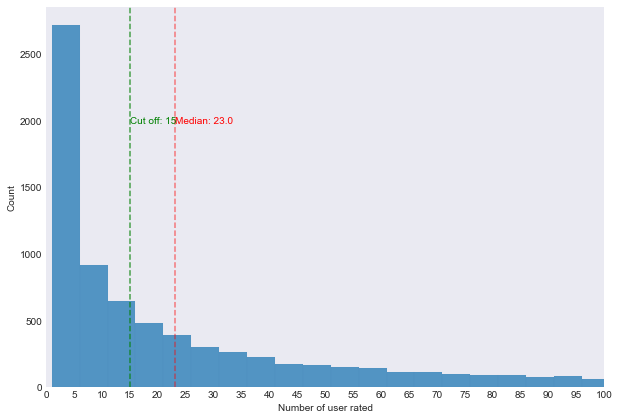

In [24]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.histplot(x='num_user', data=user_grouped, binwidth=5)
plt.xlim(0, 100)
ax.set_xticks(np.arange(0, 105, 5))
ax.set_xlabel("Number of user rated")
ax.axvline(median_num_user, color='red', linestyle='--',
           alpha=.5)
ax.text(median_num_user, 2000, f"Median: {median_num_user}", va='center',
        ha='left', color='red')
ax.axvline(15, color='green', linestyle='--',
           alpha=.7)
ax.text(15, 2000, f"Cut off: 15", va='center',
        ha='left', color='green')

In [25]:
num_remain = []
num_filter = []

for i in tqdm(range(user_grouped['num_user'].max())):
    num_remain.append((~(user_grouped['num_user'] < i)).sum())
    num_filter.append(i)

  0%|          | 0/34899 [00:00<?, ?it/s]

Text(0.5, 0, 'Number of filtered user rated')

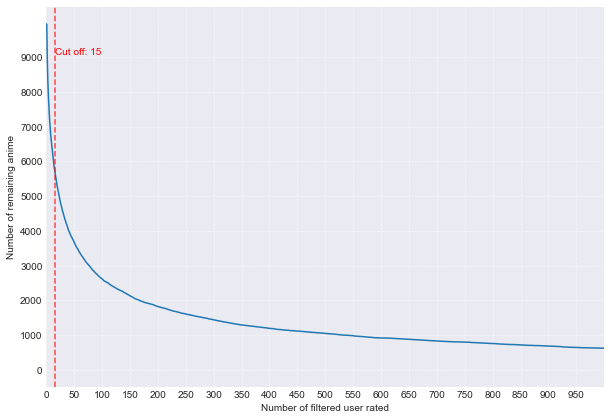

In [26]:
fig, ax = plt.subplots(figsize=(10, 7))

sns.lineplot(x=num_filter, y=num_remain)
ax.set_xticks(np.arange(0, 1000, 50))
ax.set_yticks(np.arange(0, 10000, 1000))
ax.grid(linestyle='--', alpha=.5)
ax.set_xlim(0, 1000)

ax.axvline(15, color='red', linestyle='--', alpha=.7)
ax.text(15, 9000, f"Cut off: 15", ha='left', color='red', va='bottom')

ax.set_ylabel('Number of remaining anime')
ax.set_xlabel('Number of filtered user rated')

In [27]:
game_id_min = user_grouped.loc[user_grouped['num_user'] >= 15, 'item_id'].values
rating_df_min = rating_df_min[rating_df_min['item_id'].isin(game_id_min)] # filter game rated users >= 15

### Filter each player must play game at least 10 games

In [28]:
user_grouped = rating_df_min.groupby(['user_id'])['item_id'].count().reset_index(name='num_rate_game')
user_grouped

,user_id,num_rate_game
0,--000--,39
1,--ace--,23
2,--ionex--,20
3,-2SV-vuLB-Kg,42
4,-404PageNotFound-,105
...,...,...
67633,zzonci,1
67634,zzoptimuszz,46
67635,zzydrax,2
67636,zzyfo,44


In [29]:
median_num_rate_game = user_grouped['num_rate_game'].median()
print(f"Median of number game rated: {median_num_rate_game}")

Median of number game rated: 27.0


Text(10, 10700, 'Cut off: 10')

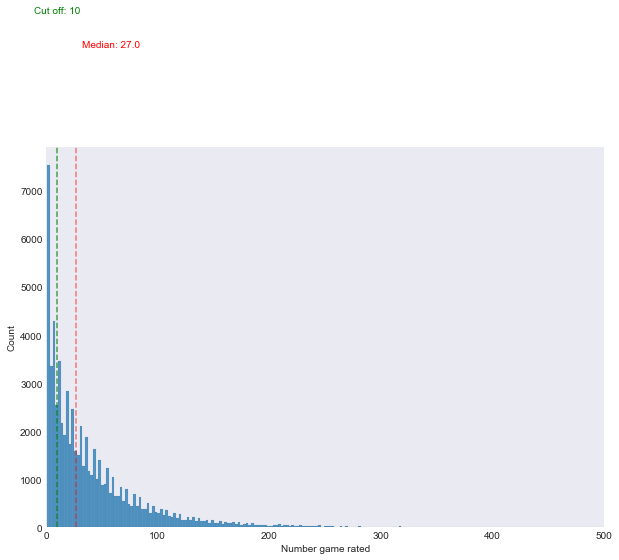

In [30]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.histplot(x='num_rate_game', data=user_grouped)
plt.xlim(0, 500)
ax.set_xlabel("Number game rated")
ax.axvline(median_num_rate_game, color='red', linestyle='--',
           alpha=.5)
ax.text(median_num_rate_game+5, 10000, f"Median: {median_num_rate_game}", 
        ha='left', color='red')
ax.axvline(10, color='green', linestyle='--',
           alpha=.7)
ax.text(10, 10700, f"Cut off: 10", 
        ha='center', color='green')

In [31]:
num_remain = []
num_filter = []

for i in tqdm(range(user_grouped['num_rate_game'].max())):
    num_remain.append((~(user_grouped['num_rate_game'] < i)).sum())
    num_filter.append(i)

  0%|          | 0/3056 [00:00<?, ?it/s]

Text(0.5, 0, 'Number of filtered rated game')

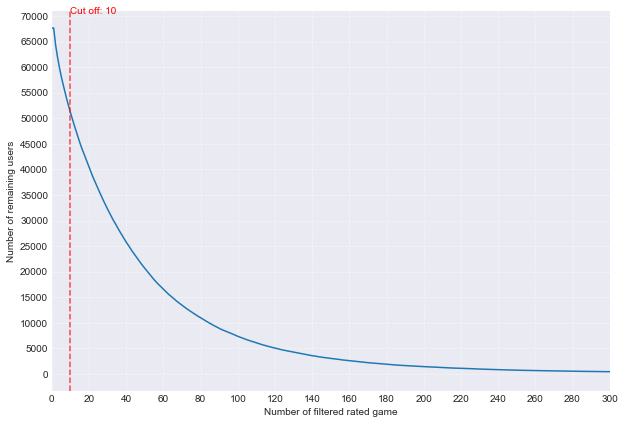

In [32]:
fig, ax = plt.subplots(figsize=(10, 7))

sns.lineplot(x=num_filter, y=num_remain)
ax.set_xticks(np.arange(0, 510, 20))
ax.set_yticks(np.arange(0, 71000, 5000))
ax.grid(linestyle='--', alpha=.5)
ax.set_xlim(0, 300)

ax.axvline(10, color='red', linestyle='--', alpha=.7)
ax.text(10, 70000, f"Cut off: 10", ha='left', color='red', va='bottom')

ax.set_ylabel('Number of remaining users')
ax.set_xlabel('Number of filtered rated game')

In [33]:
user_id_min = user_grouped.loc[user_grouped['num_rate_game'] >= 10, 'user_id'].values
rating_df_min = rating_df_min[rating_df_min['user_id'].isin(user_id_min)] # filter user rated games >= 10

In [34]:
# Make playtime to have range between 0 - 10
rating_df_min['playtime_scaled'] =  rating_df_min['playtime_scaled'] *10

## Data Visualization

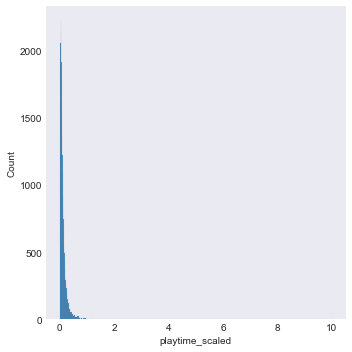

In [35]:
mean_rate_df = rating_df_min.groupby(['user_id'])['playtime_scaled'].median()
mean_rate_df = mean_rate_df.reset_index()
sns.displot(x='playtime_scaled', data=mean_rate_df)

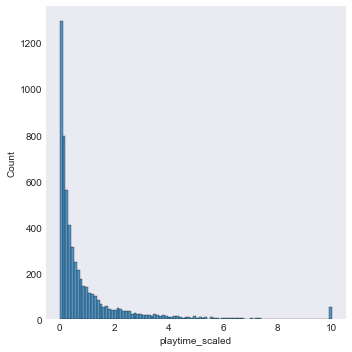

In [36]:
game_mean_rate_df = rating_df_min.groupby(['item_id'])['playtime_scaled'].median()
game_mean_rate_df = game_mean_rate_df.reset_index()
sns.displot(x='playtime_scaled', data=game_mean_rate_df)

In [37]:
game_grouped_df = rating_df_min.groupby(['item_name'])['user_id'].count().reset_index(name='rating_cnt')
game_grouped_df = game_grouped_df.sort_values(['rating_cnt'], ascending=False).reset_index(drop= True)

Text(0.5, 1.0, 'Top 10 game based on number of users rated')

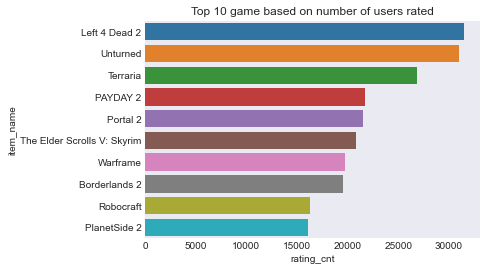

In [38]:
sns.barplot(y='item_name', x='rating_cnt', data=game_grouped_df.head(10))
plt.title("Top 10 game based on number of users rated")

In [39]:
game_id_filter = game_grouped_df.loc[game_grouped_df['rating_cnt'] >= 100, 'item_name'] # filter anime rated more than 100 users
game_id_filter.values

array(['Left 4 Dead 2', 'Unturned', 'Terraria', ..., 'Underrail',
       'Arx Fatalis', 'Reaper - Tale of a Pale Swordsman'], dtype=object)

In [40]:
rating_df_filter = rating_df_min.loc[rating_df_min['item_name'].isin(game_id_filter.values)]
game_grouped_df = rating_df_filter.groupby(['item_name'])['playtime_scaled'].mean().reset_index(name='rating_mean')
game_grouped_df = game_grouped_df.sort_values(['rating_mean'], ascending=False)

Text(0.5, 1.0, 'Top 10 game based on mean of rating')

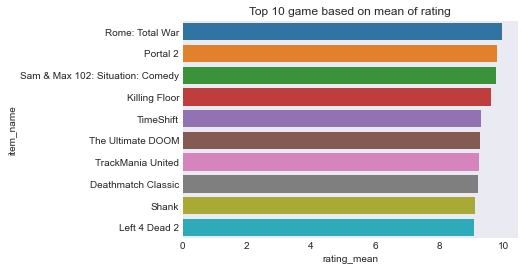

In [41]:
sns.barplot(y='item_name', x='rating_mean', data=game_grouped_df.head(10))
plt.title("Top 10 game based on mean of rating")

## Modeling

In [42]:
rating_df_min

,user_id,item_id,item_name,playtime_scaled
0,76561197970982479,10,Counter-Strike,0.031438
1,76561197970982479,30,Day of Defeat,0.437500
2,76561197970982479,2630,Call of Duty 2,0.942951
3,76561197970982479,6400,Joint Task Force,10.000000
4,76561197970982479,6910,Deus Ex: Game of the Year Edition,10.000000
...,...,...,...,...
3069872,76561198312638244,286690,Metro 2033 Redux,0.029617
3069873,76561198312638244,238010,Deus Ex: Human Revolution - Director's Cut,0.222501
3069874,76561198312638244,362890,Black Mesa,1.665142
3069875,76561198312638244,400040,ShareX,0.003317


In [43]:
rating_df_min.groupby(['user_id'])['item_id'].count().min() # Check min game

10

In [44]:
rating_df_min.groupby(['item_id'])['user_id'].count().min() # Check min user

13

### Train - Validation - Test set

In [45]:
# Test set has one game for each users 
rating_grouped_df = rating_df_min.groupby(['user_id'])
test_df = rating_grouped_df.apply(lambda x: x.sample(n = 1, random_state=1))
test_df.index = test_df.index.droplevel(level=0)
train_df = rating_df_min[~rating_df_min.index.isin(test_df.index)]

In [2]:
# Data ratio 9 train : 1 valid for each users
train_df = train_df.reset_index(drop=True)
train_grouped_df = train_df.groupby(['user_id'])
valid_df = train_grouped_df.apply(lambda x: x.sample(frac=.1, random_state=1))
valid_df.index = valid_df.index.droplevel(level=0)
train_df = train_df[~train_df.index.isin(valid_df.index)]

### Data Loader

In [ ]:
train_df = train_df.copy()
train_df['is_valid'] = 0

valid_df = valid_df.
copy()
valid_df['is_valid'] = 1

train_valid_df = pd.concat([train_df, valid_df], axis=0)
train_valid_df

In [ ]:
user_name   = 'user_id'
item_name   = 'item_id'
rating_name = 'playtime_scaled'
cat_names = [user_name,item_name]
splits = ColSplitter(col='is_valid')(train_valid_df)
to = TabularCollab(train_valid_df, [Categorify], cat_names, y_names=[rating_name], y_block=TransformBlock(), splits=splits)
dls = to.dataloaders(bs=256)

In [ ]:
dls.show_batch()

In [ ]:
print("Verify train set")
print(len(dls.train_ds))
print(len(train_df))

print("Verify validation set")
print(len(dls.valid_ds))
print(len(valid_df))

### Neural Network

In [ ]:
wandb.init(project='game-recommend')

In [ ]:
emb_szs = {'user_id': 50, 'item_id': 50 }
szs = get_emb_sz(dls.train_ds, emb_szs)
print(f"Embedding size (user, item): {szs}, {emb_szs}")
learn = collab_learner(dls, # Dataloader ที่จะนำมา train model
                       y_range=(0, 10.5), # Range ของค่าคะแนน rating
                       use_nn=True, # ใช้ Neural Network
                       emb_szs=emb_szs, # กำหนดขนาดของ Embedding
                       metrics=[mse, # Metrics ที่ใช้วัดผล
                                mae]).to_fp16()

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, # epoch
                    lr_max=1e-2, # learning rate
                    wd=0.1,
                    cbs=[WandbCallback(),
                        SaveModelCallback()])

In [ ]:
learn.model

## Prediction

We use top k accuracy method:
assume top 3


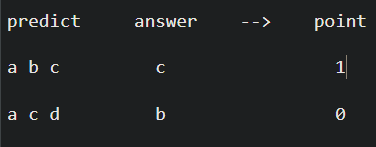


top 3 accuraccy -> sum of point / n = 0.5 

In [ ]:
check = train_valid_df.drop(['is_valid','item_name'], axis = 1)
data = df
check

In [ ]:
all_ans = pd.DataFrame(columns = {'user_id','item_id','playtime_scaled','pred'})

for j in range(test_df.shape[0]):
    user = train_df['user_id'].unique()[j]

    # Create dataframe contains games of each users never play
    df = pd.DataFrame()
    df['user_id'] = user
    # df คือ ข้อมูลทั้งหมด , check คือ ข้อมูลของ train และ valid
    df['item_id'] = np.setdiff1d(data['item_id'].unique(), check[check['user_id'] == user]['item_id'].unique())
    df['user_id'] = user
    df['playtime_scaled'] = np.NaN
    
    # Predict time for each game
    test_dls = dls.test_dl(df)
    test_pred, test_target = learn.get_preds(dl=test_dls)
    
    # Keep all top 10 most playtime for each users
    df['pred'] = test_pred
    df = df.sort_values(by='pred',ascending = False).drop(df.iloc[10:].index, axis =0)
    all_ans = pd.concat([all_ans, df])
    print(j)

In [ ]:
# Top 10 most users play 
user_sum = data.groupby(['item_id'])['user_id'].nunique().sort_values(ascending = False)[:10].index
user_sum

In [ ]:
# Top 10 mean playtime
playtime_mean = data.groupby(['item_id'])['playtime_scaled'].mean().sort_values(ascending = False)[0:10].index
playtime_mean

In [ ]:
# Top 10 playtime
playtime_sum = data.groupby(['item_id'])['playtime_scaled'].sum().sort_values(ascending = False)[:10].index
playtime_sum

In [ ]:
test = test_df
top10 = [0,0,0,0] # model, user, mean, sum

In [ ]:
for i in range(test.shape[0]):
    user = test['user_id'].unique()[i]
    ans = test[test['user_id'] == user]['item_id'].values[0]
    
    if ans in ans_key[ans_key['user_id'] == user]['item_id'].values:
        top10[0] += 1
    if ans in user_sum:
        top10[1] += 1
    if ans in playtime_mean:
        top10[2] += 1
    if ans in playtime_sum:
        top10[3] += 1
        
    print(i, " ", end='')

In [ ]:
top10[0] /= test.shape[0]
top10[1] /= test.shape[0]
top10[2] /= test.shape[0]
top10[3] /= test.shape[0]
top10

In [ ]:
result = pd.DataFrame()
result['Model'] = ['Neural Network', 'Most users', 'Mean of playtime', 'Sum of playtime']
result['Top 10 accuracy'] = top10
result

### Test with top 10 -  20 of Most user

From top10 user is the most accuracy. It means top10 users is so popular. So I want to watch if we cut of top10 users from test set, and use top10 users with new test set. How will it be.  

In [ ]:
# take out top 10 of most user and playtime
top10user = data.groupby(['item_id'])['user_id'].nunique().sort_values(ascending = False)[:10].index
for i in range(10):
    test = test[test['item_id'] != top10user[i]]

In [ ]:
# Top 10 - 20 most users play 
user_sum = data.groupby(['item_id'])['user_id'].nunique().sort_values(ascending = False)[10:20].index
user_sum

In [ ]:
top20 = [0,0,0,0] # model, user, mean, sum

In [ ]:
for i in range(test.shape[0]):
    user = test['user_id'].unique()[i]
    ans = test[test['user_id'] == user]['item_id'].values[0]
    
    if ans in ans_key[ans_key['user_id'] == user]['item_id'].values:
        top20[0] += 1
    if ans in user_sum:
        top20[1] += 1
    if ans in playtime_mean:
        top20[2] += 1
    if ans in playtime_sum:
        top20[3] += 1
        
    print(i, " ", end='')

In [ ]:
top20[0] /= test.shape[0]
top20[1] /= test.shape[0]
top20[2] /= test.shape[0]
top20[3] /= test.shape[0]
top20

In [ ]:
result = pd.DataFrame()
result['Model'] = ['Neural Network', 'Most users', 'Mean of playtime', 'Sum of playtime']
result['Top 10 accuracy'] = top20
result

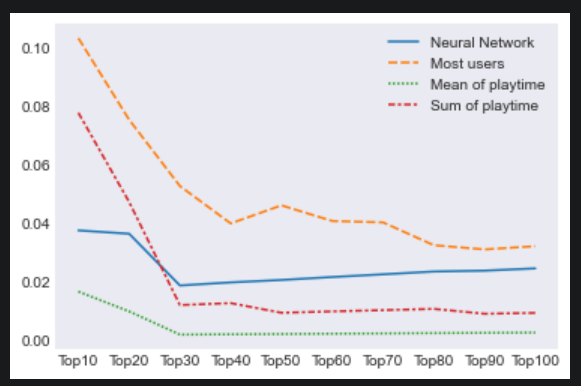

## Find Similiar

In [ ]:
# Get embedding
user_embeds = learn.model.embeds[0].weight
item_embeds = learn.model.embeds[1].weight
user_ids = learn.dls.train_ds.classes['user_id']
item_ids = learn.dls.train_ds.classes['item_id']

In [ ]:
def find_similar_game(game_name):
    print(f"Game name: {game_name}")
    game_id =  data[data['item_name'] == game_name]['item_id'].unique()[0]
    arr_idx = item_ids.o2i[game_id]
    similar = nn.CosineSimilarity(dim=1)(item_embeds, item_embeds[arr_idx][None])
    sim_arr_idx = similar.argsort(descending=True)
    most_sim_idx = sim_arr_idx[1:6]
    least_sim_idx = sim_arr_idx[-5:]
    sim_ani_id = np.concatenate((item_ids[most_sim_idx], item_ids[least_sim_idx]))
    
    sim_df = pd.DataFrame()
    for id in sim_ani_id:
        sim_df = sim_df.append([data[data['item_id'] == id]['item_name'].unique()[0]])
    sim_df.columns = ['Name']
    sim_df['similar'] = np.concatenate((similar[most_sim_idx].cpu().detach().numpy(), similar[least_sim_idx].cpu().detach().numpy()))
    return sim_df

In [ ]:
name = df['item_name'].nunique()
interact(find_similar_game, game_name=name)